# Driven Turbulence: DG-2 - FV-1 Hybrid Scheme

* DG-2 (Np = 1) stabilized with Persson-indicated Subcell-FV
* Effective Resolution: 128 cells x 2 nodes = 256
* equation of state: isothermal
* Mach-5 turbulent driver

In [16]:
import sys

sys.path.append('/home/jmark/projects/turbubox/tools/lib')

import interpolate as itpl
import matplotlib.pyplot as plt

import numpy as np
import glob
import h5
import gausslobatto
import ulz
import interpolate
import shellavg

%matplotlib inline

dpi = 180//2
figsize = (780/dpi,640/dpi)

resol = 1024 # image resolution

In [17]:
#fpath = '/mnt/data/couchdg/blast/2d/data/chkpt_0010.h5'
fpath = list(sorted(glob.glob('/mnt/data/couchdg/stirturb/2d-Np1-Mach5/data/chkpt_*.h5')))[-1]
h5file = h5.File(fpath)
print(fpath)

gamma = 1.4

setup = "Driven Turbulence"

extent = (0,1,0,1)

/mnt/data/couchdg/stirturb/2d-Np1-Mach5/data/chkpt_0028.h5


In [18]:
def get_data(dname):
    return [h5file.get('/ranks/{}/{}'.format(rank,dname)) for rank in h5file.get('/ranks').keys()]

def dg2fv(patch,Nvisu=None,Ntype='gauss-lobatto'):
    Np = patch.shape[-1]-1
    Nv = Nvisu if Nvisu else 2*Np + 1

    xs = gausslobatto.mk_nodes(Np, Ntype)
    Xs = ulz.mk_body_centered_linspace(-1,1, Nv)

    return interpolate.change_grid_space_2d(patch,xs,Xs)

def stitch(levels, morton, patches, shape=(resol,resol), trafo=lambda x: x, method='nearest'):
    image = np.zeros(shape)
    for l,m,p in zip(levels,morton,patches):
        if len(p.shape) > 1: p = trafo(p)
        itpl.cells_to_image(l,m,p,image,method)
    return image

#trafo = lambda x: x
trafo = dg2fv

#def pressure(dens,momx,momy,ener,gamma=1.4):
#    return (gamma-1)*(ener - 0.5*(momx**2+momy**2)/dens)

def pressure(dens,momx,momy,ener,gamma=1.4):
    return dens

In [19]:
levels = get_data('levels')
morton = get_data('morton')
states = get_data('data/hydro/state')
glodof = get_data('data/hydro/dof')
persso = get_data('data/hydro/persson')
dilati = get_data('data/amr/dilation')
timest = get_data('data/hydro/timesteps')

xlimit = get_data('data/hydro/xlimit')
ylimit = get_data('data/hydro/ylimit')

xdilat = get_data('data/hydro/xdilat')
ydilat = get_data('data/hydro/ydilat')

moelim = get_data('data/hydro/moe')

accs = get_data('data/forcing/accs')

dens = stitch(levels, morton, [s[:,0,:,:].transpose(0,2,1) for s in states],trafo=trafo,method='bilinear')
momx = stitch(levels, morton, [s[:,1,:,:].transpose(0,2,1) for s in states],trafo=trafo,method='bilinear')
momy = stitch(levels, morton, [s[:,2,:,:].transpose(0,2,1) for s in states],trafo=trafo,method='bilinear')
ener = stitch(levels, morton, [s[:,3,:,:].transpose(0,2,1) for s in states],trafo=trafo,method='bilinear')
pres = pressure(dens,momx,momy,ener)
mach = np.sqrt((momx/dens)**2+(momy/dens)**2)/np.sqrt(gamma*pres/dens)

accx = stitch(levels, morton, [s[:,0,:,:].transpose(0,2,1) for s in accs],trafo=trafo,method='bilinear')
accy = stitch(levels, morton, [s[:,1,:,:].transpose(0,2,1) for s in accs],trafo=trafo,method='bilinear')

tstep = stitch(levels, morton, [s.value.transpose(0,2,1) for s in timest],trafo=trafo,method='bilinear')

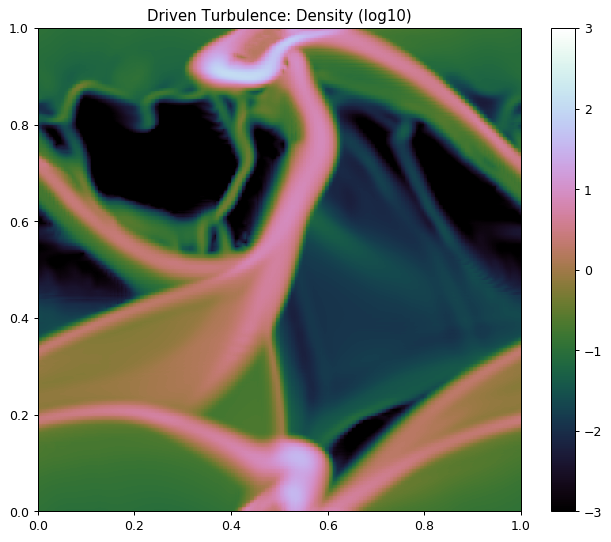

In [20]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Density (log10)'.format(setup))

plt.imshow(
    np.log10(dens),
    extent = extent,
    vmin = -3,
    vmax =  3,
    cmap = 'cubehelix',
    origin = 'lower left',  
)
plt.colorbar()

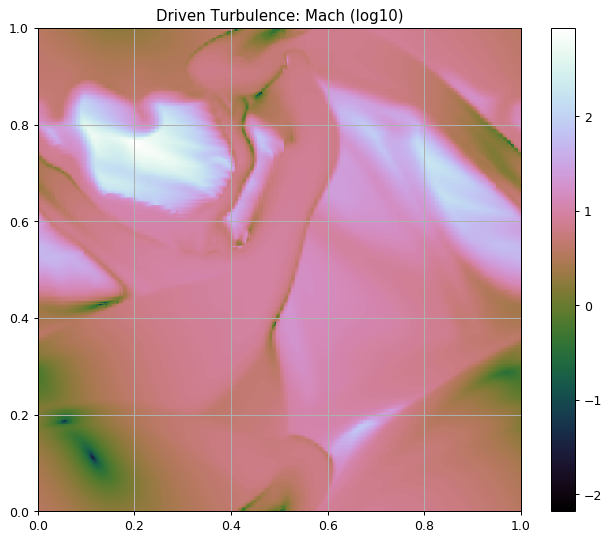

In [21]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Mach (log10)'.format(setup))

plt.grid()

plt.imshow(
    np.log10(mach),
    #mach,
    extent = extent,
    #vmin = 0,
    #vmax = 200,
    cmap = 'cubehelix',
    origin = 'lower left',  
)
plt.colorbar()

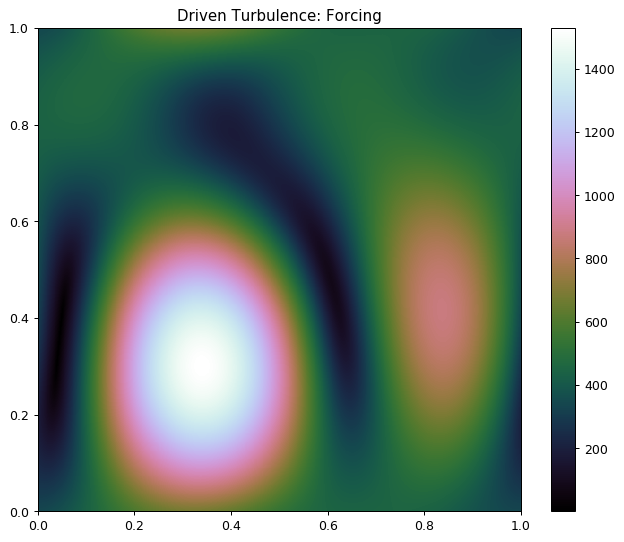

In [22]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Forcing'.format(setup))

plt.imshow(
    np.sqrt(accx**2+accy**2),
    extent = extent,
    #vmin = 0,
    #vmax = 2,
    cmap = 'cubehelix',
    origin = 'lower left',  
)
plt.colorbar()

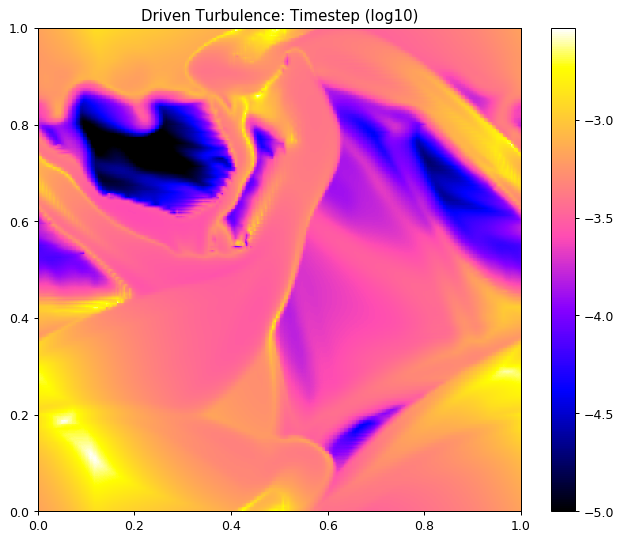

In [23]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Timestep (log10)'.format(setup))

plt.imshow(
    np.log10(tstep),
    extent = extent,
    vmin = -5,
    #vmax = -2,
    cmap = 'gnuplot2',
    origin = 'lower left',  
)
plt.colorbar()

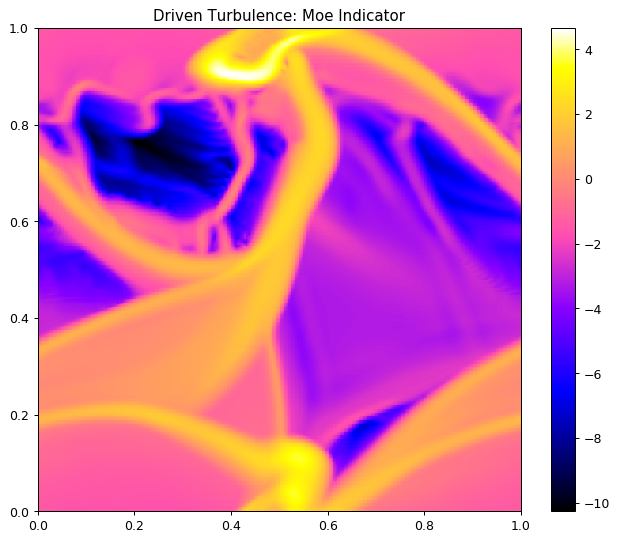

In [24]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Moe Indicator'.format(setup))

plt.imshow(
    np.log10(dens*pres*np.log10(1/tstep)),
    #dens*pres*tstep,
    extent = extent,
    #vmin = -5,
    #vmax = -2,
    cmap = 'gnuplot2',
    origin = 'lower left',  
)
plt.colorbar()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


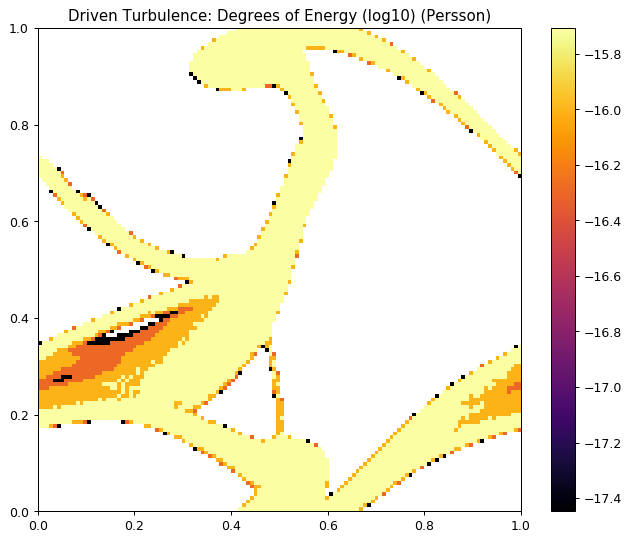

In [25]:
data = stitch(levels, morton, glodof,method='bilinear')
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Degrees of Energy (log10) (Persson)'.format(setup))

plt.imshow(
    np.log10(data+1e-16),
    extent = extent,
    #vmin = -10,
    #vmax = 0,
    cmap = 'inferno',
    origin = 'lower left',  
)
plt.colorbar()

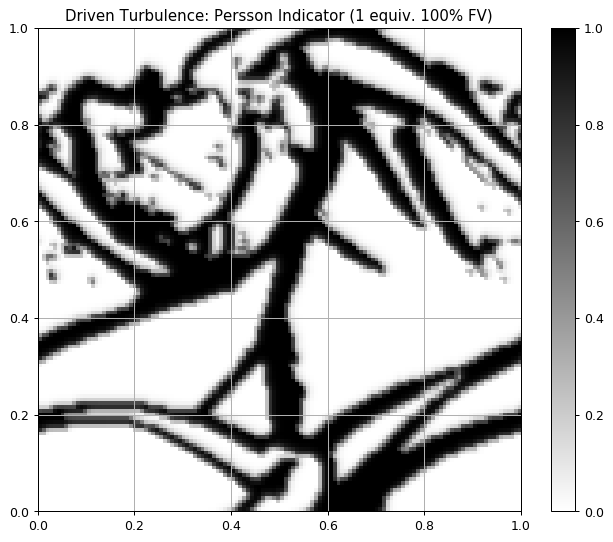

In [26]:
data = stitch(levels, morton, persso,method='nearest')
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Persson Indicator (1 equiv. 100% FV)'.format(setup))

plt.grid()
plt.imshow(
    data,
    extent = extent,
    vmin = 0,
    vmax = 1,
    cmap = 'gray_r',
    origin = 'lower left',  
)
plt.colorbar()

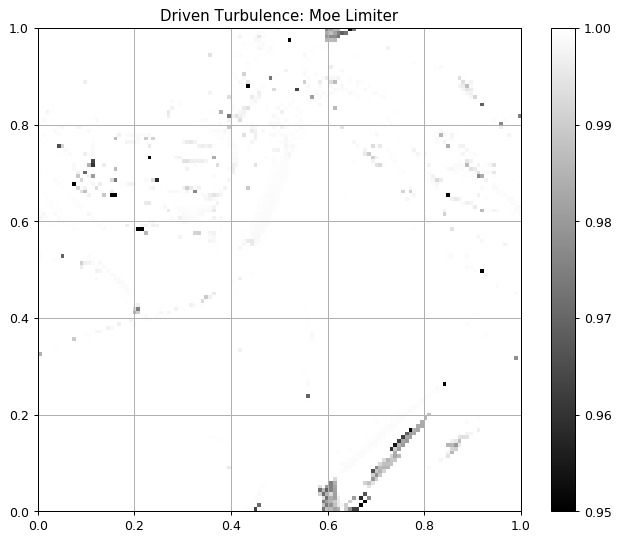

In [27]:
data = stitch(levels, morton, moelim, method='nearest')
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Moe Limiter'.format(setup))
plt.grid()
plt.imshow(
    data,
    extent = extent,
    vmin = 0.95,
    vmax = 1.0,
    cmap = 'gray',
    origin = 'lower left',  
)
plt.colorbar()

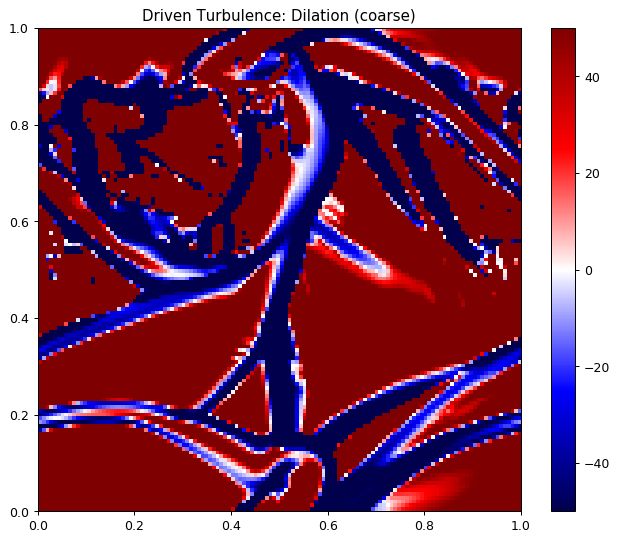

In [28]:
data = stitch(levels, morton, dilati,method='nearest')

fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Dilation (coarse)'.format(setup))

plt.imshow(
    data,
    extent = extent,
    vmin = -50,
    vmax =  50,
    cmap = 'seismic',
    origin = 'lower left',  
)
plt.colorbar()

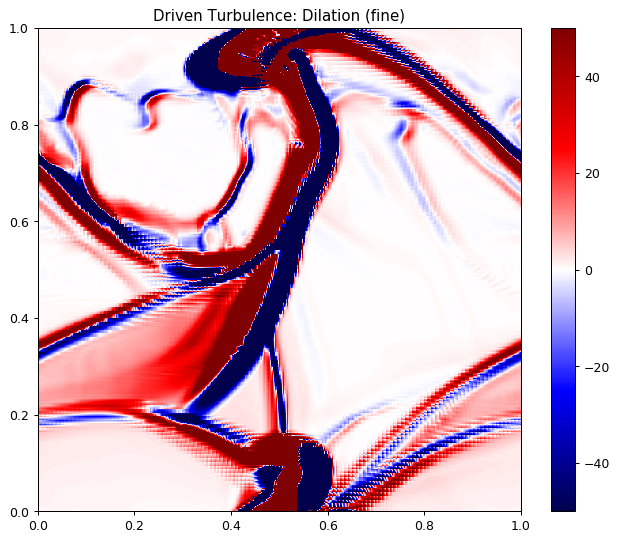

In [29]:
xdata = stitch(levels, morton, [xl.value.transpose(0,2,1) for xl in xdilat],method='bilinear')
ydata = stitch(levels, morton, [xl.value.transpose(0,2,1) for xl in ydilat],method='bilinear')

data = 0.5*(xdata+ydata)

fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: Dilation (fine)'.format(setup))

plt.imshow(
    data,
    extent = extent,
    vmin = -50,
    vmax =  50,
    cmap = 'seismic',
    origin = 'lower left',  
)
plt.colorbar()

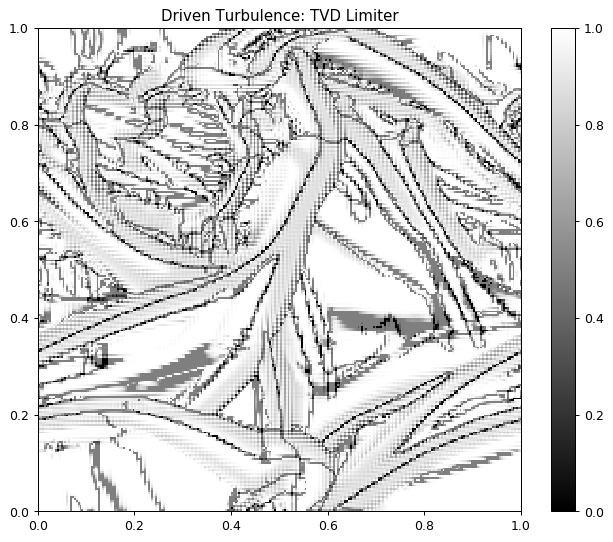

In [30]:
xdata = stitch(levels, morton, [xl.value.transpose(0,2,1) for xl in xlimit],method='nearest')
ydata = stitch(levels, morton, [xl.value.transpose(0,2,1) for xl in ylimit],method='nearest')
pdata = stitch(levels, morton, persso,method='nearest')

#data = 1-pdata*(1-0.5*(xdata+ydata))
data = 0.5*(xdata+ydata)


fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('{}: TVD Limiter'.format(setup))

plt.imshow(
    data,
    extent = extent,
    vmin = 0.0,
    vmax = 1.0,
    cmap = 'gray',
    origin = 'lower left',  
)
plt.colorbar()